In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import abc
from abc import ABC, abstractmethod

from utils import eq_covariance,                 \
                  sample_datasets_from_gps,      \
                  gp_post_pred,                  \
                  np_plot_sample_and_predictions

# Sample and plot a few datapoints

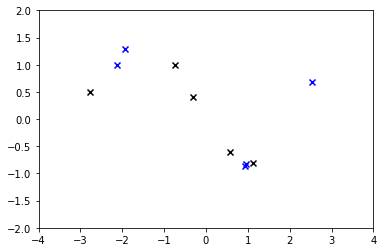

In [2]:
train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=5,
                                                 num_test=5,
                                                 scale=1e0,
                                                 cov_coeff=1e0,
                                                 noise_coeff=1e-1,
                                                 as_tensor=True)
                                    
plt.scatter(train_data[0][0], train_data[1][0], marker='x', color='black')
plt.scatter(test_data[0][0], test_data[1][0], marker='x', color='blue')

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.show()

# NP definition

In [127]:
# class NeuralProcess(nn.Module):
    
#     def __init__(self,
#                  cond_lik,
#                  encoder,
#                  prior):
        
#         super().__init__()
        
#         self.cond_lik = cond_lik
#         self.encoder = encoder
#         self.prior = prior
        
#         self.normal = torch.distributions.Normal
        
        
#     def forward(self,
#                 context_inputs,
#                 context_outputs,
#                 target_inputs):
        
#         context_inputs = context_inputs.unsqueeze(dim=-1)
#         context_outputs = context_outputs.unsqueeze(dim=-1)
#         target_inputs = target_inputs.unsqueeze(dim=-1)
        
#         context = torch.cat([context_inputs, context_outputs], dim=-1)
        
#         theta_post_params = self.encoder(context)
#         theta_post_params = torch.mean(theta_post_params, dim=1)[:, None, :]
#         theta_post_params = torch.reshape(theta_post_params,
#                                           theta_post_params.shape[:-1] + (-1, 2))
        
#         theta_mean = theta_post_params[:, :, :, 0]
#         theta_stdev = torch.exp(theta_post_params[:, :, :, 1])
        
#         theta_post = torch.distributions.Normal(theta_mean, theta_stdev)
        
#         theta_sample = theta_post.rsample()
        
#         kl_divergence = torch.distributions.kl_divergence(theta_post, prior)
        
#         theta_sample = theta_sample.repeat(1, target_inputs.shape[1], 1)
#         tensor = torch.cat([target_inputs, theta_sample], dim=-1)
        
#         tensor = self.cond_lik(tensor)
#         tensor = torch.reshape(tensor, tensor.shape[:2] + (-1, 2))
        
#         mean, log_stdev = tensor[:, :, :, 0], tensor[:, :, :, 1]
        
#         return mean, log_stdev, kl_divergence, theta_sample
    
    
#     def _loss(self,
#               context_inputs,
#               context_outputs,
#               target_inputs,
#               target_outputs):
        
#         target_outputs = target_outputs.unsqueeze(dim=-1)
        
#         mean, log_stdev, kl_divergence, _ = self.forward(context_inputs,
#                                                          context_outputs,
#                                                          target_inputs)
        
#         stdev = torch.exp(log_stdev)
        
#         cond_dist = self.normal(loc=mean, scale=stdev)
        
#         log_prob = cond_dist.log_prob(target_outputs)
        
#         log_prob = torch.mean(log_prob, dim=0)
#         log_prob = torch.sum(log_prob)
        
#         kl_divergence = torch.sum(kl_divergence, dim=[1, 2])
#         kl_divergence = torch.mean(kl_divergence)
        
#         elbo = log_prob - 1e-1 * kl_divergence
        
#         return - elbo
    
    
#     def loss(self,
#              inputs,
#              outputs,
#              num_samples):
        
#         loss = 0
        
#         for i in range(num_samples):
            
#             N = np.random.choice(np.arange(1, inputs.shape[1]))
            
#             context_inputs = inputs[:, :N]
#             context_outputs = outputs[:, :N]
#             target_inputs = inputs[:, N:]
#             target_outputs = outputs[:, N:]
            
#             loss = loss + self._loss(context_inputs,
#                                      context_outputs,
#                                      target_inputs,
#                                      target_outputs)
        
#         loss = loss / num_samples
        
#         return loss

In [128]:
class FeedforwardNetwork(nn.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        # Set sizes for linear layers
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        # Create linear layers
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        # Nonlinearity to use after each linear layer except the last
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        # Apply each linear layer (except last) and nonlinearity
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        # Apply last linear layer
        tensor = self.linear[-1](tensor)
        
        return tensor

In [129]:
class ConcatenationEncoder(nn.Module):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
    
    def forward(self,
                context_inputs,
                context_outputs):
        
        # Concatenate context inputs and outputs
        tensor = torch.cat([context_inputs, context_outputs], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        approx_post_params = torch.mean(tensor, dim=1)[:, None, :]
        approx_post = self.stochastic_layer(approx_post_params)
        
        return approx_post
        
    
class RepeatDecoder(nn.Module, ABC):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
        
    
    def forward(self,
                context,
                target_inputs):
        
        # Repeat context tensor for each datapoint
        context = context[:, :, None, :]
        context = context.repeat(1, 1, target_inputs.shape[1], 1)
        
        target_inputs = target_inputs[None, :, :, :]
        target_inputs = target_inputs.repeat(context.shape[0], 1, 1, 1)
        
        # Concatenate inputs and context
        tensor = torch.cat([target_inputs, context], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        cond_lik = self.stochastic_layer(tensor)
        
        return cond_lik

In [163]:
class StochasticLayer(ABC, nn.Module):
    
    def __init__(self, distribution):
        
        super().__init__()
        
        # Set the distribution to use
        self.distribution_type = getattr(torch.distributions,
                                         distribution)
        
    @abstractmethod
    def reparametrise(self, tensor):
        pass
    
    def __call__(self, tensor):
        
        # Reparametrise raw tensor to get distribution parameters
        distribution_params = self.reparametrise(tensor)
        
        # Instantiate distribution using parameters
        distribution = self.distribution_type(**distribution_params)
        
        return distribution
    
    
class NormalStochasticLayer(StochasticLayer):
    
    def __init__(self, single_noise_param, reparam_func):
        
        super().__init__(distribution='Normal')
        
        if reparam_func == 'sigmoid':
            self.reparam_func = torch.nn.Sigmoid()
            
        elif reparam_func == 'softplus':
            self.reparam_func = torch.nn.Softplus()
        
        self.single_noise_param = single_noise_param
        
        if single_noise_param:
            self.unc_scale = nn.Parameter(torch.tensor(0.))
            
        self.num_params = 1 if single_noise_param else 2
            
        
    def reparametrise(self, tensor):
        
        tensor = torch.reshape(tensor, tensor.shape[:-2] + (-1, self.num_params))
        
        loc = tensor[..., 0]
        unc_scale = self.unc_scale if self.single_noise_param else tensor[..., 1]
        
        param_dict = {'loc'   : loc,
                      'scale' : self.reparam_func(unc_scale) + 1e-3}
        
        return param_dict

In [164]:
class NeuralProcess(nn.Module):
    
    def __init__(self,
                 encoder,
                 decoder,
                 prior):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.prior = prior
    
    
    def forward(self,
                context_inputs,
                context_outputs,
                target_inputs,
                sample_output=False):
        
        # Approximate posterior of (sub-sampled) context points
        context_approx_post = self.encoder(context_inputs,
                                           context_outputs)
            
        # Sample context from approximate posterior
        context_sample = context_approx_post.rsample(sample_shape=(1,))
            
        # Pass target inputs and context sample through decoder
        cond_lik_dist = self.decoder(context_sample,
                                     target_inputs)
        
        # Sample output from conditional likelihood distribution
        if sample_output:
            return cond_lik_dist.rsample()[0]
        
        else:
            return cond_lik_dist.mean[0], cond_lik_dist.stddev[0]
    
    
    def loss(self,
             inputs,
             outputs,
             num_mc_samples,
             num_subsamples):
        
        total_log_lik = 0.
        total_kl = 0.
        total_elbo = 0.
        
        # Approximate posterior of all observed datapoints
        full_approx_post = self.encoder(inputs, outputs)
        
        for i in range(num_subsamples):
            
            # Number of context points
            N = np.random.choice(np.arange(1, outputs.shape[1] - 1))
            
            # Split context and target inputs/outputs
            context_inputs = inputs[:, :N]
            context_outputs = outputs[:, :N]
            target_inputs = inputs[:, N:]
            target_outputs = outputs[:, N:]
            
            # Approximate posterior of (sub-sampled) context points
            context_approx_post = self.encoder(context_inputs,
                                               context_outputs)

            # KL of full approx. posterior to context approx. posterior
            kl_divergence = torch.distributions.kl_divergence(full_approx_post,
                                                              context_approx_post)
            kl_divergence = torch.sum(kl_divergence, dim=-1)
            kl_divergence = torch.mean(kl_divergence)
                
            # Sample context from approximate posterior
            context_sample = full_approx_post.rsample(sample_shape=(num_mc_samples,))

            # Pass target inputs and context sample through decoder
            cond_lik_dist = self.decoder(context_sample, inputs)

            # Compute log likeelihood of target outputs
            log_lik = cond_lik_dist.log_prob(outputs[None, ..., 0])
            
            # Mean over number of MC samples and datasets, sum over datapoints
            log_lik = torch.mean(log_lik, dim=[0, 1])
            log_lik = torch.sum(log_lik)
                
            total_log_lik = total_log_lik + log_lik
            total_kl = total_kl + kl_divergence
            total_elbo = total_elbo + torch.mean(log_lik) - torch.mean(kl_divergence)
        
        # Compute ELBO for current nuumber of subsamples
        total_log_lik = total_log_lik / num_subsamples
        total_kl = total_kl / num_subsamples
        total_elbo = total_elbo / num_subsamples
        
        return - total_elbo, total_log_lik, total_kl

In [170]:
# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=False,
                                         reparam_func='sigmoid')

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=1,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=True,
                                         reparam_func='softplus')

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

# Training

In [173]:
# ! rm -rf ./model_checkpoints
# ! mkdir ./model_checkpoints

-32.89405822753906, -32.14847946166992, 0.7455791234970093


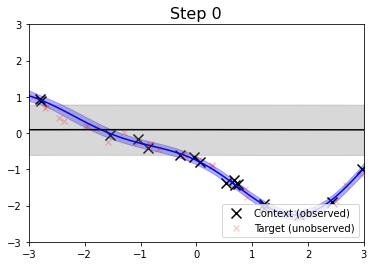

-21.249242782592773, -21.19461441040039, 0.05462764576077461


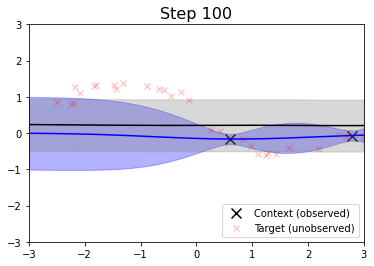

-23.69838523864746, -19.220245361328125, 4.478139877319336


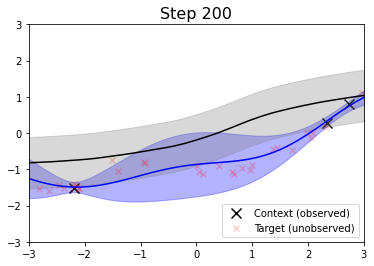

-21.38003921508789, -17.456745147705078, 3.923295021057129


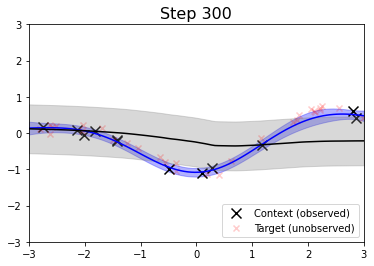

-16.134502410888672, -15.710562705993652, 0.42394039034843445


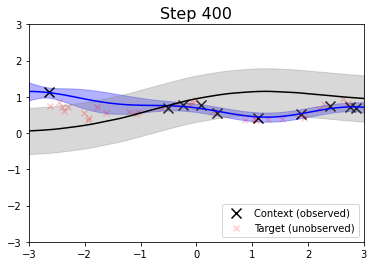

-17.350299835205078, -16.66336441040039, 0.6869348287582397


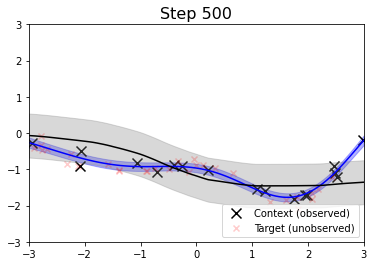

-17.466047286987305, -17.23529052734375, 0.23075585067272186


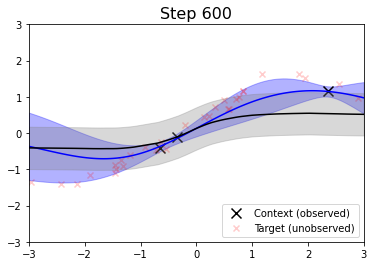

-24.882064819335938, -15.784887313842773, 9.097177505493164


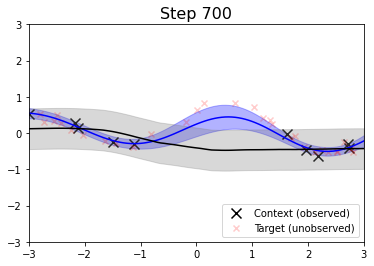

-18.896984100341797, -14.076261520385742, 4.820721626281738


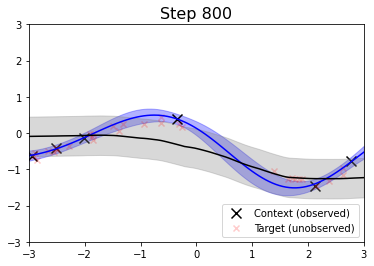

-14.019756317138672, -13.820917129516602, 0.19883891940116882


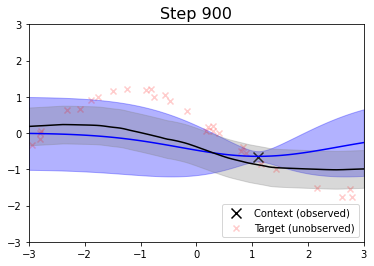

-16.94866180419922, -15.24374771118164, 1.7049144506454468


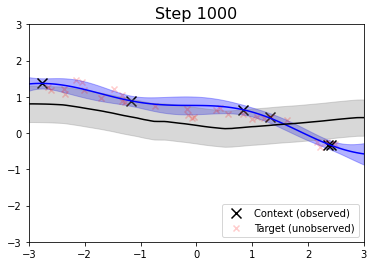

-13.99679946899414, -12.36646556854248, 1.630333662033081


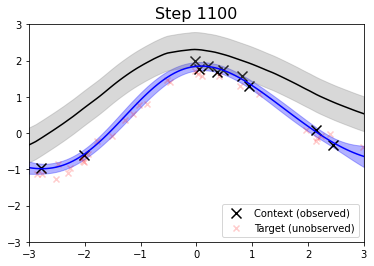

-15.397409439086914, -14.058551788330078, 1.3388575315475464


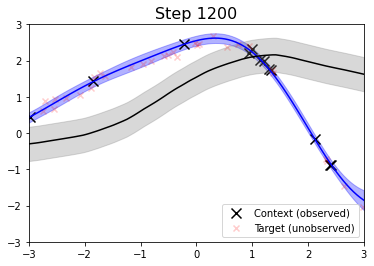

-14.250304222106934, -12.762846946716309, 1.4874573945999146


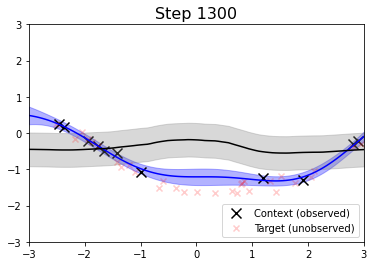

-18.728857040405273, -13.071081161499023, 5.65777587890625


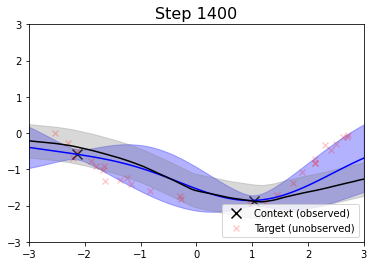

-14.829022407531738, -10.766290664672852, 4.062731742858887


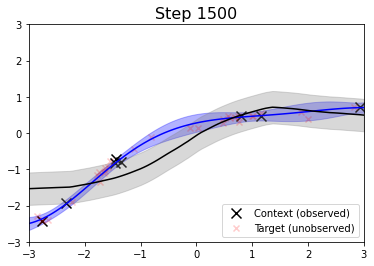

-43.65081787109375, -11.412083625793457, 32.23873519897461


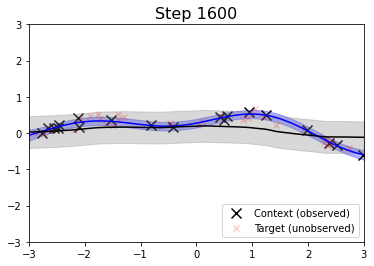

-13.933030128479004, -10.059348106384277, 3.8736820220947266


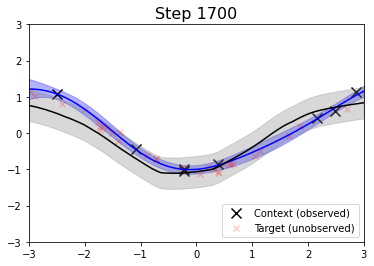

-11.150348663330078, -10.962913513183594, 0.18743528425693512


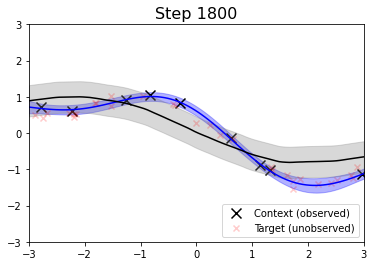

-11.708734512329102, -11.401277542114258, 0.3074566721916199


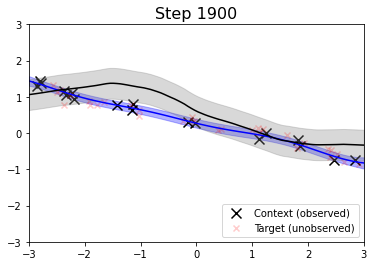

-13.765209197998047, -11.638519287109375, 2.126690149307251


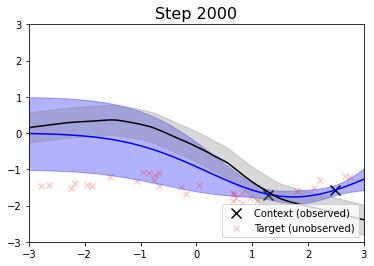

-11.518101692199707, -11.365608215332031, 0.15249335765838623


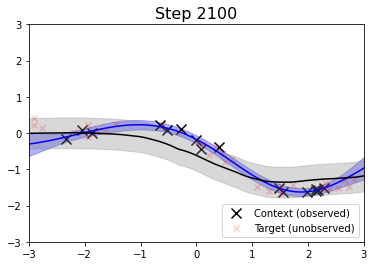

-12.690805435180664, -10.94611930847168, 1.7446856498718262


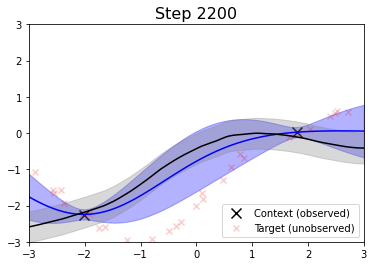

-10.12020492553711, -9.838223457336426, 0.28198182582855225


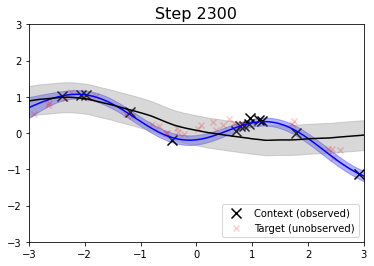

-14.739791870117188, -12.672504425048828, 2.0672876834869385


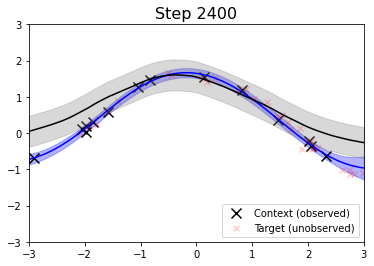

-11.967144012451172, -11.81554126739502, 0.15160275995731354


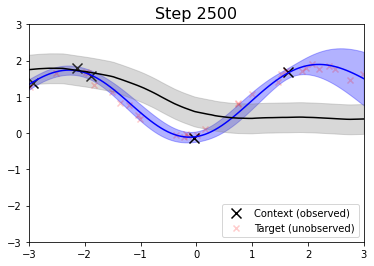

-10.447114944458008, -9.360349655151367, 1.0867655277252197


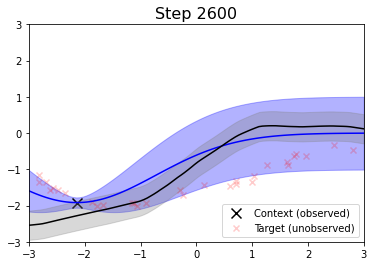

-15.837270736694336, -9.750722885131836, 6.086547374725342


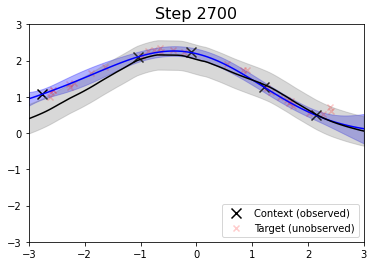

-12.081976890563965, -11.452747344970703, 0.6292294263839722


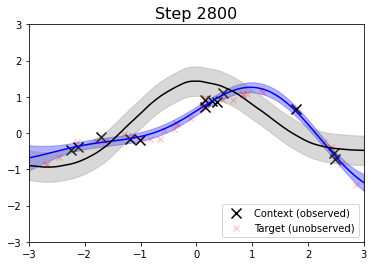

-17.34551429748535, -11.181221008300781, 6.1642937660217285


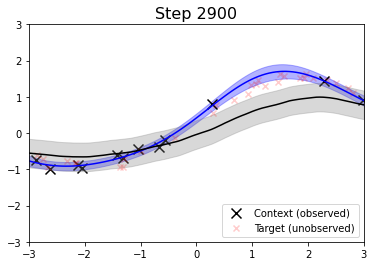

-15.014850616455078, -11.131799697875977, 3.8830511569976807


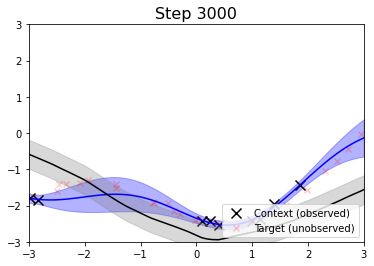

-9.377642631530762, -8.76983642578125, 0.6078062653541565


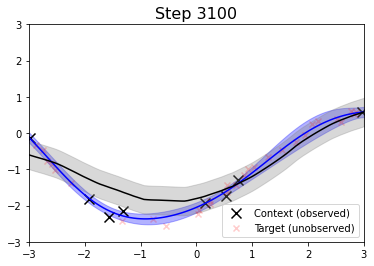

-17.646270751953125, -9.566027641296387, 8.080244064331055


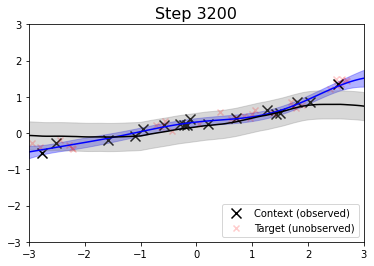

In [ ]:
# Dataset parameters
batch_size = 50
num_train = 20
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
plot_input_range = (-3., 3.)

# Neural Process parameters
num_mc_samples = 10
num_subsamples = 1

# Training parameters and optimizer
num_train_steps = int(1e5)
lr = 1e-3

# Plotting parameters
data_low = -3.
data_high = 3.

# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=False,
                                         reparam_func='sigmoid')

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=1,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer(single_noise_param=True,
                                         reparam_func='softplus')

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

# Optimizer
optimizer = torch.optim.Adam(neural_process.parameters(), lr=lr)

losses = []

for i in range(num_train_steps):
    
    optimizer.zero_grad()
    
    train_data, test_data = sample_datasets_from_gps(data_low,
                                                     data_high,
                                                     batch_size,
                                                     num_train,
                                                     num_test,
                                                     scale,
                                                     cov_coeff,
                                                     noise_coeff,
                                                     as_tensor)
    
    inputs, outputs = train_data
    
    loss, log_lik, kl_divergence = neural_process.loss(inputs=train_data[0],
                                                       outputs=train_data[1],
                                                       num_mc_samples=num_mc_samples,
                                                       num_subsamples=num_subsamples)
    
    loss.backward()
    optimizer.step()
    
    if i % 1e2 == 0:
        
        num_train_plot = np.random.choice(np.arange(1, num_train))
        
        print(f'{-loss.detach().numpy()}, {log_lik.detach().numpy()}, {kl_divergence.detach().numpy()}')
        
        np_plot_sample_and_predictions(neural_process=neural_process,
                                       low=data_low,
                                       high=data_high,
                                       input_range=plot_input_range,
                                       num_train=num_train_plot,
                                       num_test=30,
                                       scale=scale,
                                       cov_coeff=cov_coeff,
                                       noise_coeff=noise_coeff,
                                       step=i,
                                       plot_test_data=True)
        
        torch.save(neural_process.state_dict(), f'./model_checkpoints/neural-process-chkpt-{i}')

(-3.0, 3.0)

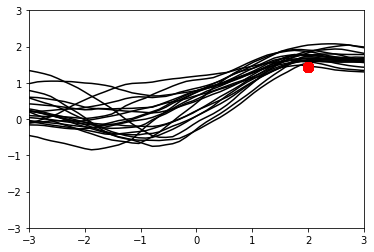

In [234]:
# Dataset parameters
num_train = 1
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
input_range = (-6., 6.)

train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=num_train,
                                                 num_test=num_test,
                                                 scale=scale,
                                                 cov_coeff=cov_coeff,
                                                 noise_coeff=noise_coeff,
                                                 as_tensor=True)

context_inputs, context_outputs = train_data
target_inputs = torch.linspace(input_range[0],
                               input_range[1],
                               100)[None, :, None]

for i in range(20):
    
    pred_mean, pred_stddev = neural_process.forward(context_inputs,
                                                    context_outputs,
                                                    target_inputs)
    
    pred_mean = pred_mean[0, :].detach().numpy()
    pred_stddev = pred_stddev[0, :].detach().numpy()
    
    plt.plot(target_inputs[0, :, 0],
             pred_mean,
             color='black',
             zorder=1)
    
    plt.scatter(train_data[0],
                train_data[1],
                color='red',
                s=100,
                zorder=2)
    
plt.xlim([-3., 3.])
plt.ylim([-3., 3.])

# Plotting epistemic and aleatoric uncertainties

(10, 100) (10, 100)
(100,)


(-3.0, 3.0)

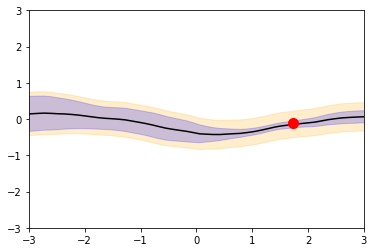

In [232]:
# Dataset parameters
num_train = 1
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
input_range = (-6., 6.)

train_data, test_data = sample_datasets_from_gps(low=-3.,
                                                 high=3.,
                                                 batch_size=1,
                                                 num_train=num_train,
                                                 num_test=num_test,
                                                 scale=scale,
                                                 cov_coeff=cov_coeff,
                                                 noise_coeff=noise_coeff,
                                                 as_tensor=True)

context_inputs, context_outputs = train_data
target_inputs = torch.linspace(input_range[0],
                               input_range[1],
                               100)[None, :, None]

pred_means = []
pred_vars = []

for i in range(10):
    
    pred_mean, pred_stddev = neural_process.forward(context_inputs,
                                                    context_outputs,
                                                    target_inputs)
    
    pred_mean = pred_mean[0, :].detach().numpy()
    pred_var = pred_stddev[0, :].detach().numpy() ** 2
    
    pred_means.append(pred_mean)
    pred_vars.append(pred_var)
    
pred_means = np.stack(pred_means, axis=0)
pred_vars = np.stack(pred_vars, axis=0)
print(pred_means.shape, pred_vars.shape)

mean = np.mean(pred_means, axis=0)

var_aleatoric = np.mean(pred_vars, axis=0)
var_epistemic = np.var(pred_means, axis=0)
var_total = var_epistemic + var_aleatoric
print(var_total.shape)
    
plt.plot(target_inputs[0, :, 0], pred_mean, color='black', zorder=1)

plt.fill_between(target_inputs[0, :, 0], 
                 pred_mean - var_total ** 0.5, 
                 pred_mean + var_total ** 0.5, 
                 color='orange',
                 alpha=0.2,
                 zorder=1)

plt.fill_between(target_inputs[0, :, 0], 
                 pred_mean - var_epistemic ** 0.5, 
                 pred_mean + var_epistemic ** 0.5, 
                 color='blue',
                 alpha=0.2,
                 zorder=1)

# plt.fill_between(target_inputs[0, :, 0], 
#                  pred_mean - pred_stddev, 
#                  pred_mean + pred_stddev, 
#                  color='gray',
#                  alpha=0.2,
#                  zorder=1)
# plt.scatter(train_data[0], train_data[1], color='red', s=100, zorder=2)
plt.scatter(train_data[0], train_data[1], color='red', s=100, zorder=2)

plt.xlim([-3., 3.])
plt.ylim([-3., 3.])